<a href="https://colab.research.google.com/github/sehan25/ESAA-2022-1/blob/main/Assignment/0513_Python_Machine_Learning_p227-p251_%26_p278-p289.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **06. XGBoost(eXtra Gradient Boost)**
---

- XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나이다.
- XGBoost의 주요 장점
    - 뛰어난 예측 성능
        - 일반적으로 분류와 회귀 영역에서 뛰어난 예측 성능을 발휘
    - GBM 대비 빠른 수행 시간
        - XGBoost는 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습 완료 가능
    - 과적합 규제(Regularization)
        - 표준 GBM의 경우 과적합 규제 기능이 없으나 XGBoost는 자체에 과적합 규제 기능으로 좀 더 강한 내구성 가지기 가능
    - Tree pruning(나무 가지치기)
        - GBM과 마찬가지로 XGBoosts max_depth 파라미터로 분할 깊이를 조정하기도 하지만, tree pruning으로 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄이기 가능
    - 자체 내장된 교차 검증
        - XGBoost는 반복 수행 시마다 내부적으로 학습 데이터 세트와 평가 데이터 세트에 대한 교차 검증을 수행해 최적화된 반복 수행 횟수 가질 수 있으며 조기 중단 기능 존재
    - 결손값 자체 처리 기능
- xgboost 패키지 내에는 XGBoost 전용의 파이썬 패키지와 사이킷런과 호환되는 래퍼용 XG Boost 가 함께 존재한다.
- xgboost 패키지에서 사이킷런과 연동할 수 있는 사이킷런 래퍼 클래스는 XGBClassifier와 XGBRegressor
    - 이를 이용하면 사이킷런 estimator가 학습을 위해 사용하는 `fit()`와 `predict()`와 같은 표준 사이킷런 개발 프로세스 및 다양한 유틸리티 활용 가능


> ### XGBoost 설치하기
> ---

```
conda install -c anaconda py-xgboost
```



> ### 파이썬 래퍼 XGBoost 하이퍼 파라미터
> ---

- XGBoost는 GBM과 유사한 하이퍼 파라미터를 동일하게 가지고 있으며, 여기에 조기 중단(early stopping), 과적합을 규제하기 위한 하이퍼 파라미 터 등이 추가되었다.
- 파이썬 래퍼 XGBoost 모듈과 사이킷런 래퍼 XGBoost 모듈의 일부 하이퍼 파라미터는 약간 다르므 로 이에 대한 주의가 필요하다.
- 파이썬 래퍼 XGBoost 하이퍼 파라미터 유형
    - 일반 파라미터: 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
        - 예) `booster`, `silent`, `nthread`
    - 부스터 파라미터: 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭
        - 예) `eta [default=0.3, alias: learning_rate]`, `num_boost_rounds`, `min_child_weight[default=1]`, `gamma [default=0, alias: min_split_loss]`, `max_depth[default=6]`, `sub_samples[default=1]`, `colsample_bytree [default=1]`, `lambda [default=1, alias: reg_lambda]`, `alpha [default=0, alias: reg_alpha]`, `scale_pos_weight [default=1]`
    - 학습 태스크 파라미터: 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정
        - 예) `objective`, `binary:logistic`, `multi:softmax`, `multi:softprob`, `eval_metric`
            - `eval_metric`의 값 유형 - `rmse`(회귀 기본값), `mae`, `logloss`, `error`(분류 기본값), `merror`, `mlogloss`, `auc`
- 뛰어난 알고리즘일수록 파라미터 튜닝할 필요가 적고 파라미터 튜닝에 들이는 공수 대비 성능 향상 효과가 높지 않는 경우가 대부분이다.
- XGBoost 자체적으로 교차 검증, 성능 평가, 피처 중요도 등의 시각화 기능 가지고 있다.
- 기본 GBM에서 부족한 다른 여러 가지 성능 향상 기능도 있다.
    - 수행 속도를 향상시키기 위한 대표적인 기능으로 조기 중단(Early Stopping)

In [1]:
import xgboost

print(xgboost.__version__)

0.90


> ### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측
> ---

위스콘신 유방암 데이터 세트: 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양(malignant)인지 양성 종양(benign)인지를 분류한 데이터 세트  

*위스콘신 유방암 데이터 세트에 기반해 종양의 다양한 피처에 따라 악성종양인지 일반 양성종양인지를 XGBoost를 이용해 예측해 보기*
- xgboost 모듈 로딩

In [2]:
## 필요한 모듈, 데이터 로딩

import xgboost as xgb
from xgboost import plot_importance #피처의 중요도 시각화 모듈
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


    타깃 레이블 값의 종류는 악성인 'malignant'가 0 값으로, 양성인 'benign'이 1값으로 되어 있음.

- 레이블 값 분포 확인

In [3]:
## 레이블 값 분포 확인

print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


- 전체 데이터 세트 중 80%를 학습용으로, 20%를 테스트용으로 분할

In [4]:
## 데이터 분할

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


- 넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환
    - 파이썬 래퍼 XGBoost는 사이킷런과 차이가 여러 가지 있지만, 먼저 눈에 띄는 차이는 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성한다는 점이다.
    - DMatrix: 주로 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트  
    주요 입력 파라미터: data, label
        - data: 피처 데이터 세트
        - label: 분류의 경우) 레이블 데이터 세트, 회귀의 경우) 숫자형인 종속값 데이터 세트

In [5]:
## 넘파이 형태의 학습 데이터 세트와 테스트 데이터 세트를 DMatrix로 변환

dtrain = xgb. DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

- XGBoost의 하이퍼 파라미터 설정
    - 파이썬 래퍼 XGBoost 모듈인 xgboost를 이용해 학습을 수행하기 전에 하이퍼 파라미터 설정
    - 주로 딕셔너리 형태로 입력
        - max_depth(트리 최대 깊이)는 3
        - 학습률 eta는 0.1(XGBClassifier)를 사용할 경우 eta가 아니라 learning_rate)
        - 예제 데이터가 0 또는 1 이진 분류이므로 목적함수(objective)는 아진 로지스틱(binary:logistic)
        - 오류 함수의 평가 성능 지표는 logloss
        - num_rounds(부스팅 반복 횟수)는 400회

In [6]:
## 하이퍼 파라미터 설정

params = { 'max_depth':3,
           'eta': 0.1,
           'objective': 'binary:logistic',
           'eval_metric': 'logloss',
           'early_stoppings': 100
          }
num_rounds = 400

- 지정된 하이퍼 파라미터로 XGBoost 모델 학습
    - 파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 `train()` 함수에 파라미터로 전달  
    (사이킷런의 경우는 Estimator의 생성자를 하이퍼 파라미터로 전달)
    - 조기 중단은 xgboost의 `train()` 함수에 `early_stopping_rounds` 파라미터를 입력하여 설정
        - `early_stopping_rounds` 파라미터를 설정해 조기 중단을 수행하기 위해서는 반드시 `eval_set`과 `eval_ metric`이 함께 설정되어야 함
        - Xgboost는 반복마다 `eval set`으로 지정된 데이터 세트에서 `eval_ metric`의 지정된 평가 지표로 예측 오류를 측정
            - `eval_set`: 성능 평가를 수행할 평가용 데이터 세트 설정
            - `eval_metric`: 평가 세트에 적용할 성능 평가 방법. 분류일 경우 주로 '`error`'(분류 오류), '`logloss`' 적용

In [7]:
## XGBoost 모델 학습 (조기 중단 최소 반복 횟수를 100으로 설정)

# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, \
                      early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logl

    train()으로 학습을 수행하면 반복 시 train-error와 eval-logloss가 지속적으로 감소함.
- 학습이 완료된 모델을 이용해 테스트 데이터 세트에 예측 수행
    - 파이썬 래퍼 XGBoost는 `train()` 함수를 호출해 학습이 완료된 모델 객체를 반환하게 되 는데, 이 모델 객체는 예측을 위해 `predict()` 메서드를 이용
    - 한 가지 유의할 점은 사이킷런의 `predict()` 메서드는 예측 결과 클래스 값(즉, 0, 1)을 반환하는 데 반해 xgboost의 `predict()`는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환
        - 본 예제는 암이 악성인지, 양성인지를 판단하는 이진 분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 결과 값을 결정하는 로직을 추가

In [8]:
## 테스트 데이터 세트에 예측 수행

pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


- XGBoost 모델의 예측 성능 평가
    - 3장 평가에서 생성한 `get_clf_eval()` 함수 적용

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)

    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [10]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


- xgboost 패키지에 내장된 시각화 기능 수행
    - plot_importance() API는 피처의 중요도를 막대그래프 형식으로 나타냄
        - 기본 평가 지표로 f1 스코어를 기반으로 해 각 피처의 중요도를 나타냄
        - 호출 시 파라미터로 앞에서 학습이 완료된 모델 객체 및 맷플롯립의 ax 객체를 입력하기만 하면 됨
    - 사이킷런은 Estimator 객체의 feature_importances_ 속성을 이용해 직접 시각화 코드 작성해야 하지만, xgboost 패키지는 plot_importance()를 이용해 바로 피처 중요도를 시각화 가능

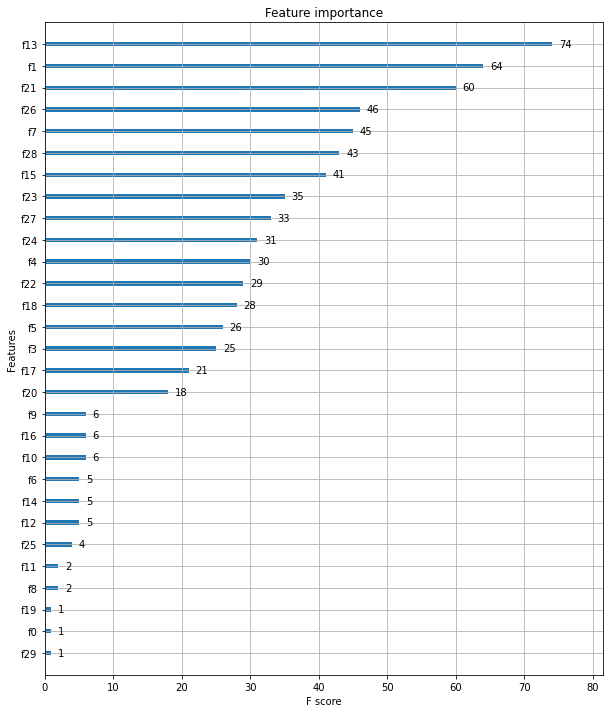

In [11]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

    내장된 plot_importance() 이용 시 유의할 점은 xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수가 없으므로 피처 순서별로 f자 뒤에 순서를 붙여서 X축에 피처들로 나열
    (즉, f0은 첫 번째 피처, f1는 두 번째 피처 의미)

- 결정 트리에서 보여준 트리 기반 규칙 구조도 xgboost에서 시각화 가능
    - `to_graphviz()` API를 이용하면 바로 규칙 트리 구조 그리기 가능
- 파이썬 래퍼 XGBoost는 사이킷런의 GridSearchCV와 유사하게 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법을 `cv()` API로 제공
    ```
xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=vone, feval=None, maximize=false, early_stopping_rounds=one, fpreproc=vone, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)
    ```
    - `params` (dict): 부스터 파라미터
    - `dtrain` (DMatrix): 학습 데이터
    - `num_boost_round` (int): CV 폴드 개수
    - `nfold` (int): CV 폴드 개수
    - `stratified` (bool): CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부 
    - `metrics` (string or list of strings): CV 수행 시 모니터링할 성능 평가 지표 
    - `early_stopping_rounds` (int): 조기 중단을 활성화시킴. 반복 횟수 지정


> ### 사이킷런 래퍼 XGBoost의 개요 및 적용
> ---

- XGBoost 개발 그룹은 사이킷런의 프레임워크와 연동하기 위해 사이킷 런 전용의 XGBoost 래퍼 클래스를 개발하였다.
- 다른 Estimator와 동일하게 fit( )과 predict( )만으로 학습과 예측이 가능하고, GridSearchCV, Pipeline 등 사이킷런의 다른 유틸리티를 그대로 사용 가능하기 때문에 기존의 다른 머신러닝 알고리즘으로 만들어놓은 프로그램이 있더라도 알고리즘 클래스만 XGboost 래퍼 클래스로 바꾸면 기존 프로그램을 그대로 사용 가능하다.
- 사이킷런을 위한 래퍼 XGBoost는 크게 분류를 위한 래퍼 클래스인 XGBClassifier, 회귀를 위한 래퍼 클래스인 XGBRegressor이다.
    - XGBClassifer는 기존 사이킷런에서 일반적으로 사용하는 하이퍼 파라미터와 호환성을 유지하기 위해 기존의 xgboost 모듈에서 사용하던 네이티브 하이퍼 파라미터 몇 개를 다음과 같이 변경
        - eta -> learning_rate
        - sub_sample -> subsample
        - lambda -> reg_lambda
        - alpha -> reg_alpha
-  xgboost의 `n_estimators`와 `num_boost_round` 하이퍼 파라미터는 서로 동일한 파라미터로, 만일 두 개가 동시에 사용되면 파이썬 래퍼 XGBoost API에서는 `n_estimators` 파라미터를 무시하고 `num_boost_round` 파라미터를 적용하지만, 사이킷런 래퍼 XGBoost 클래스에서는 `n_estimators` 파라미터를 적용

*위스콘신 유방암 데이터 세트를 분류를 위한 래퍼 클래스인 XGBClassifier를 이용해 예측*
- XGBClassifier 클래스의 `fit()`, `predict()`, `predict_proba()`를 이용해 학습과 예측 수행

In [12]:
## XGBClassifier를 이용해 학습과 예측 수행

# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

- `get_clf_eval()`를 이용해 사이킷런 래퍼 XGBoost로 만들어진 모델 예측 성능 평가

In [13]:
## 모델 예측 성능 평가

get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC:0.9951


    앞 예제의 파이썬 래퍼 XGBoost와 동일한 평가 결과 나옴.

- 사이킷런 래퍼 XGBoost에서도 조기 중단을 수행할 수 있다.
    - 조기 중단 관련한 파라미터를 `fit()`에 입력하면 됨
    -  조기 중단 관련 파라미터는 평가 지표가 향상될 수 있는 반복 횟수를 정의하는 `early_stopping_rounds`, 조기 중단을 위한 평가 지표인 `eval_metric`, 그리고 성능 평가를 수행할 데이터 세트인 `eval_set`
        - 성능 평가를 수행할 데이터 세트는 학습 데이터가 아니라 별도의 데이터 세트여야 함  
        (본 예제에서는 데이터 세트의 크기가 작아 테스트 데이터를 평가용으로 사용)

In [14]:
## 사이킷런 래퍼 XGBoost에서도 조기 중단 수행

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

    n_estimators를 400으로 설정해도 400번 반복을 수행하지 않고 311번 반복한 후 학습을 완료함.
    211에서 311번까지 early_stopping_rounds=100으로 지정된 100번의 반복 동안 성능 평가 지수가 향상되지 않았기 때문에 더 이상 반복하지 않고 멈춘 것임.

- 조기 중단으로 학습된 XGBClassifier의 예측 성능 살펴보기

In [15]:
## 조기 중단으로 학습된 예측 성능 확인

get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC:0.9954


    조기 중단이 적용되지 않은 결과보다 약간 저조한 성능 나타내지만, 큰 차이는 아님.

- 조기 중단값 줄여 예측 성능 다시 측정
    - 조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 큼
    - 아직 성능이 향상될 여지가 있음에도 불구하고 성능 평가 지표가 향상되지 않으면 반복이 멈춰 버려서 충분한 학습이 되지 않아 예측 성능이 나빠질 가능성 있음

In [16]:
## 조기 중단값 10으로 하여 다시 예측 성능 확인

# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10,
                eval_metric="logloss", eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


- 피처 중요도 시각화
    - 피처의 중요도를 시각화하는 모듈인 `plot_importance()` API에 사이킷런 래퍼 클래스를 입력해도 앞에서 파이썬 클래스를 입력한 결과와 똑같이 시각화 결과 도출

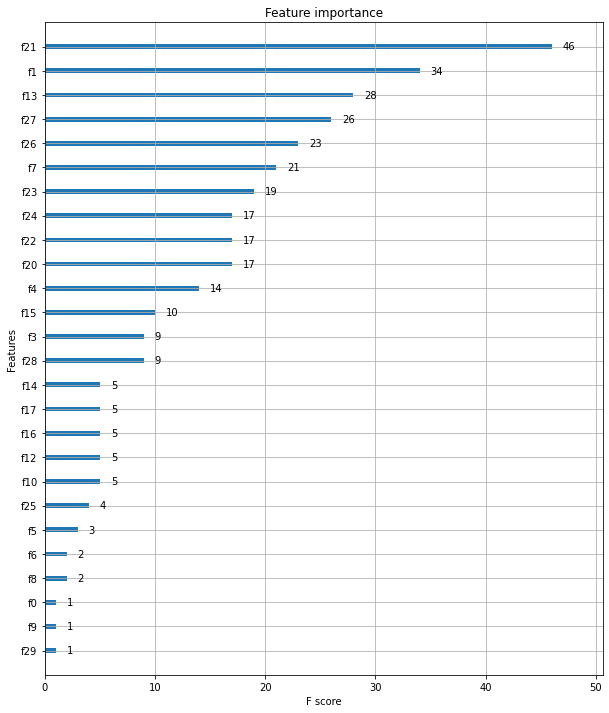

In [17]:
## 피처 중요도 시각화

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

### **07. LightGBM**
---

- LightGBM은 XGBoost와 함께 부스팅 계열 알고리즘에서 가장 각광 받고 있다.
- LightGBM의 가장 큰 장점은 XGBoost보다 학습에 걸리는 시간이 훨씬 적다는 점이다. 또한 메모리 사용량도 상대적으로 적다.
- LightGBM과 XGBoost의 예측 성능은 별다른 차이가 없다. 또한 기능상의 다양성은 LightGBM이 약간 더 많다.
- LightGBM의 한 가지 단점으로 알려진 것은 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다는 것이다. 일반적으로 10,000건 이하의 데이터 세트 정도이다.
- LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 사용한다. 기존의 대부분 트리 기반 알고리즘은 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할(Level Wise) 방식을 사용한다.
    -  LightGBM의 리프 중심 트리 분할 방식은 트리의 균형을 맞추지 않고, 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성됨
    - 최대 손실값을 가지는 리프 노드를 지속적으로 분할해 생성된 규칙 트리는 학습을 반복할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화 할 수 있다는 것이 LightGBM의 구현 사상
-  LightGBM은 XGBoost와 마찬가지로 다음과 같은 대용량 데이터에 대한 뛰어난 예측 성능 및 병 렬 컴퓨팅 기능을 제공하고 있으며, 추가로 최근에는 GPU까지 지원한다.
- LightBGM의 파이썬 패키지인 lightbgm 패키지 내에 파이썬 래퍼용 LightGBM, 사이킷런 래퍼 LightGBM, 두 래퍼 모듈 모두 가지고 있다.
    - 사이킷런 래퍼 LightGBM 클래스는 분류를 위한 LGBMClassifier 클래스와 회귀를 위한 LGBMRegressor 클래스

> ### LightGBM 설치
> ---

```
conda install -c conda-forge lightgbm
```



> ### LightGBM 하이퍼 파라미터
> ---

- 주요 파라미터
    - `num_iterations` [default=100]: 반복 수행하려는 트리의 개수 지정
    - `learning_rate` [default=0.1]: 0에서 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이터되는 학습률 값
    - `max_depth` [default=-1]: 트리 기반 알고리즘의 `max_depth`와 같음
    - `min_data_in_leaf` [default=20]: 결정 트리의 `min_samples_leaf`와 같은 파라미터, 최종 결정 클래스인 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수이며 과적합을 제어하기 위한 파라미터
    - `num_leaves` [default=31]: 하나의 트리가 가질 수 있는 최대 리프 개수
    - `boosting` [default=gbdt]: 부스팅의 트리를 생성하는 알고리즘 기술
        - `gbdt`: 일반적인` `그래디언트 부스팅 결정 트리
        - `rf`: 랜덤 포레스트
    - `bagging_fraction` [default=1.0]: 트리가 과적합되는 것을 제어하기 위해서 데이터를 샘플링하는 비율을 지정
    - `feature_fraction` [default=1.0]: 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율
    - `lamda_l2` [defalut=0.0]: L2 regulation 제어를 위한 값
    - `lambda_l1` [default=0.0]: L1 regulation 제어를 위한 값

- Learning Task 파라미터
    - `objective`: 최솟값을 가져야 할 손실함수 정의. Xgboost objective 파라미터와 동일. 회귀, 다중 클래스 분류, 이진 분류인지에 따라서 objective인 손실함수가 지정

    

> ### 하이퍼 파라미터 튜닝 방안
> ---

- `num_leaves`의 개수를 중심으로 `min_child_samples`(`min_data_in_leaf`), `max_depth`를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안이다.
    - `num_leaves`는 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미터임. 일반적으로 `num_leaves`의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커짐
    - `min_data_in_leaf`는 사이킷런 래퍼 클래스에서는 `min_child_samples`로 이름이 바뀜. 과적합을 개선하기 위한 중요한 파라미터임. `num_leaves`와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지함
    - `max_depth`는 명시적으로 깊이의 크기를 제한함. `num_leaves`, `min_data_in_leaf`와 결합해 과적합을 개선하는 데 사용함
- `learning_rate`를 작게 하면서 `n_estimators`를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋다.
- 이밖에 과적합을 제어하기 위해서 `reg_lambda`, `reg_alpha`와 같은 regularization을 적용하거나 학 습 데이터에 사용할 피처의 개수나 데이터 샘플링 레코드 개수를 줄이기 위해 `colsample _bytree`, `subsample` 파라미터를 적용 가능하다.


> ### 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교
> ---

|파이썬 래퍼 LightGBM|사이킷런 래퍼 LightGBM|사이킷런 래퍼 XGBoost|
|---|---|---|
|num_iterations|n_estimators|n_estimatros|
|learing_rate|learning_rate|learning_rate|
|max_depth|max_depth|max_depth|
|min_data_in_leaf|min_child_samples|N/A|
|bagging_fraction|subsample|subsample|
|feature_fraction|colsample_bytree|colsample_bytree|
|lambda_l2|reg_lambda|reg_lambda|
|lambda_l1|reg_alpha|reg_alpha|
|early_stopping_round|early_stopping_rounds|early_stopping_rounds|
|num_leaves|num_leaves|N/A|
|min_sum_hessian_in_leaf|min_child_weight|min_child_weight|

## LightGBM 적용 - 위스콘신 유방암 예측

*위스콘신 유방암 데이터 세트를 이용해 LightGBM으로 예측*
- lightbgm에서 LGBMClassifier를 임포트해 사용

In [18]:
## 필요한 모듈 로딩, 조기 중단 수행

# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

- 학습된 LightGBM 모델을 기반으로 예측 성능 평가

In [19]:
## 학습된 LightGBM 모델을 기반으로 예측 성능 평가

get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740, F1: 0.9615, AUC:0.9926


- lightgbm은 XGBoost 파이썬 패키지인 xgboost와 동일하게 피처 중요도를 시각화할 수 있는 내장 API `plot_importance()` 제공한다.
- 사이킷런 래퍼 클래스를 입력해도 시각화 제공한다.

## **10. 스태킹 앙상블**
--- 

- 스태킹(Stacking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 앞에 소개 한 배경(Bagging) 및 부스팅(Boosting)과 공통점을 가진다.
- 가장 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 것이다. 즉, 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식이다.
- 스태킹 모델은 두 종류의 모델이 필요하다.
    - 첫 번째는 개별적인 기반 모델
    - 두 번째는 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
- 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이다.
- 스태킹을 적용할 때는 많은 개별 모델이 필요하다. 2~3개의 개별 모델만을 결합해서는 쉽게 예측 성능을 향상시킬 수 없으며, 스태킹을 적용한다고 해서 반드시 성능 향상이 되리라는 보장도 없다.

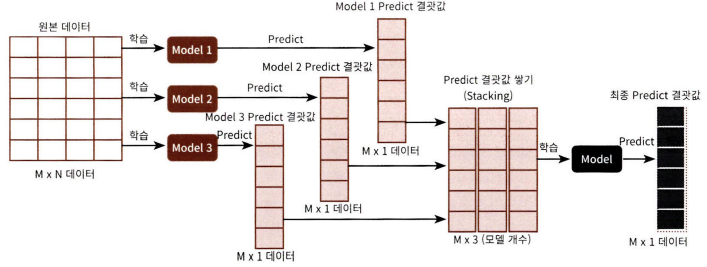

> ### 기본 스태킹 모델
> ---

*기본 스태킹 모델을 위스콘신 유방암 데이터 세트에 적용*
- 데이터 다시 로딩하고 학습 데이터 세트와 테스트 데이터 세트로 나누기

In [20]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

- 스태킹에 사용될 머신러닝 알고리즘 클래스를 생성
    - 개별 모델은 KNN, 랜덤 포레스트, 결정 트리, 에이다부스트이며, 이들 모델의 예측 결과를 합한 데이터 세트로 학습/예측하는 최종 모델은 로지스틱 회귀

In [21]:
## 사용될 머신러닝 알고리즘 클래스 생성

# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

- 개별 모델 학습

In [22]:
## 개별 모델 학습

# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

- 개별 모델의 예측 데이터 세트를 반환하고 각 모델의 예측 정확도 확인

In [23]:
## 개별 모델의 예측 데이터 세트를 반환하고 각 모델의 예측 정확도 확인

# 학습된 개별 모델들이 각자 변환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561 :


- 개별 알고리즘으로부터 예측된 예측값을 칼럼 레벨로 옆으로 붙여서 피처 값으로 만들어, 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용
    - 반환된 예측 데이터 세트는 1차원 형태의 ndarray이므로 먼저 반환된 예측 결과를 행 형태로 붙인 뒤, 넘파이의 `transpose()`를 이용해 행과 열 위치를 바꾼 ndarray로 변환하면 됨


In [24]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦 
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


- 예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델인 로지스틱 회귀 학습하고 예측 정확도 측정


In [25]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737
